In [ ]:
# imports
%load_ext autoreload
%autoreload 2
import torch.nn as nn
import torch
import re
from skimage import io
import sys
import numpy as np
from tqdm import tqdm 
import cv2
from PIL import Image
import torchvision
from torchvision import transforms as pth_transforms
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F
import os
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
#from RevenuePredictorViT import RevenuePredictorViT
!git clone https://github.com/facebookresearch/dino
sys.path.append('dino')
from dino import vision_transformer as vits

In [2]:
# set to GPU if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
args_vit = {"arch": "vit_small",
 "patch_size": 8,
 "out_dim": 65536,
 "norm_last_layer": False,
 "warmup_teacher_temp": 0.04,
 "teacher_temp": 0.07,
 "warmup_teacher_temp_epochs": 30,
 "use_fp16": False,
 "weight_decay": 0.04,
 "weight_decay_end": 0.4,
 "clip_grad": 0,
 "batch_size_per_gpu": 64,
 "epochs": 800,
 "freeze_last_layer": 1,
 "lr": 0.0005,
 "warmup_epochs": 10,
 "min_lr": 1e-05,
 "global_crops_scale": [0.25,
 1.0],
 "local_crops_scale": [0.05,
 0.25],
 "local_crops_number": 10,
 "seed": 0,
 "num_workers": 10,
 "world_size": 16,
 "ngpus": 8,
 "nodes": 2,
 "optimizer": "adamw",
 "momentum_teacher": 0.996,
 "use_bn_in_head": False,
 "drop_path_rate": 0.1,
 "image_path": "./test_img/airbud.jpeg",
 "threshold": None,
 "image_size": (480, 480),
 "output_dir": "./"
}

args = {
   "avgpool": False,
    "last_n_blocks": 4, # TODO change this, this is what eval linear does
    "n_dnn_img_features": 16,
    "n_features": 14,
    "n_output_bins": 6,
    "batch_size": 64, # TODO change this?
}

path_prefix = './'

Optional: for running on google colab

In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
path_prefix = '/content/drive/My Drive/'

# Load Data
Parameters
- csv
- number of entries to load (default all)
- path to images
- image transform function

Returns
- imgs
- features
- revenue (label?)

In [4]:
def img_rename(img_name):
    return re.sub(r'\W+', ' ', img_name).lower().strip().replace(' ', '+') + '.jpg'

def resize_poster(img, target_size):
    img_resized = resize(img, (target_size, int(img.shape[1] * (target_size / img.shape[0]))), anti_aliasing=True)
    pad_size_1 = (target_size - img_resized.shape[1]) // 2
    pad_size_2 = target_size - img_resized.shape[1] - pad_size_1
    padding = [(0, 0), (pad_size_1, pad_size_2), (0, 0)]
    if len(img_resized.shape) == 2: # gray scale image
        padding = [(0, 0), (pad_size_1, pad_size_2)]
    img_padded = np.pad(img_resized, padding, mode='constant', constant_values=0)
    return img_padded

class FeatureDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform, device, n_output_bins, n_max=None):
        # load csv data
        md_df = pd.read_csv(csv_path)
        
        # Groups numerical revenue, currently 6 bins
        num = range(n_output_bins)

        revenue_in = pd.qcut(md_df['domestic_box_office'] + md_df['international_box_office'], q=n_output_bins, labels=num)

        enc = OneHotEncoder().fit(np.array(revenue_in).reshape(-1,1))
        df = pd.DataFrame(enc.transform(np.array(revenue_in).reshape(-1,1)).toarray())
        df['combine'] = df.values.tolist()
        md_df['revenue_bin'] = df['combine']
        
        movie_data = np.pad(md_df.to_numpy(), [(0, 0), (0, 1)], mode='constant', constant_values=np.nan)
        
        # restrict dataset for testing purposes
        if n_max:
            movie_data = movie_data[:n_max,:]
        
        # TODO TRANSFORM FEATURES FROM CSV SOMEHOW
        
        # load image data
        for i in range(movie_data.shape[0]):
            img_path = img_dir + img_rename(movie_data[i,7])
            try:
                img = transform(io.imread(img_path))
            except FileNotFoundError:
                pass
            movie_data[i, -1] = img
        
        self.movie_data = movie_data
        
    def __len__(self):
        return self.movie_data.shape[0]

    def __getitem__(self, idx):
        
        movie = self.movie_data[idx]
        
        revenue_id = 10
        
        img = torch.tensor(movie[-1]).to(torch.float32).swapaxes(0,2)
        label = torch.tensor(movie[-2]) # set this to whatever the revenue entry is
        features = np.delete(movie, (revenue_id, revenue_id+1, -1)) # remove image and revenue from non-image features
        
        # TODO idk how we're representing the dnn features so I'm just gonna make a dummy
        features = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14]).to(torch.float32)
        
        # MAKE THE SIZES WORK FOR VIT
        #img = img.swapaxes(0,2).unsqueeze(0).to(torch.float32)
        #features = features.unsqueeze(0)
        
        return img, features, label

In [63]:
def load_dataset(csv_name, poster_dir):
    # TODO change transform function if desired
    img_size = 250
    transform = lambda x: resize_poster(x, img_size) 

    full_dataset = FeatureDataset(
        csv_path=path_prefix+csv_name,
        img_dir=path_prefix+poster_dir,
        transform=transform,
        device=device,
        n_max=50,
        n_output_bins=args['n_output_bins']
    )

    test_pct, val_pct = 0.3, 0.1
    test_size = int(len(full_dataset)*test_pct)
    dataset_size = len(full_dataset) - test_size
    val_size = int(dataset_size*val_pct)
    train_size = dataset_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    train_dl = DataLoader(train_dataset, args['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
    val_dl = DataLoader(val_dataset, args['batch_size'], num_workers=0, pin_memory=True)
    test_dl = DataLoader(test_dataset, args['batch_size'], num_workers=0, pin_memory=True)

    return train_dataset, val_dataset, test_dataset, train_dl, val_dl, test_dl

In [ ]:
train_dataset, val_dataset, test_dataset, train_dl, val_dl, test_dl = load_dataset('MovieDataEnhanced.zip', 'poster_img/')

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])
tensor([0., 0., 1., 0., 0., 0.])


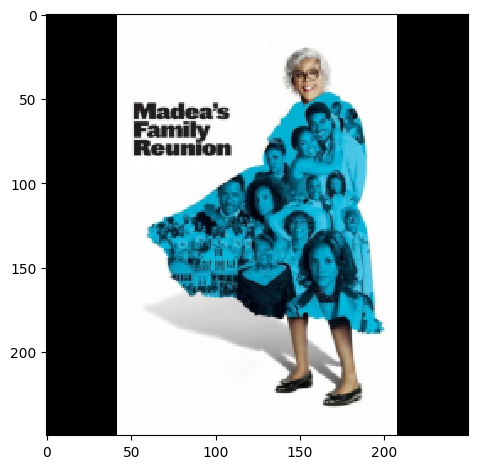

In [51]:
# test sampling dataset
img, features, label = train_dataset[0]
print(features)
io.imshow(img.swapaxes(0,2).detach().numpy())
print(label)

# Misc

In [52]:
# load image
image_path = "./test_img/airbud.jpeg"
with open(image_path, 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')
transform = pth_transforms.Compose([
    pth_transforms.Resize(args_vit['image_size']),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args_vit['patch_size'], img.shape[2] - img.shape[2] % args_vit['patch_size']
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // args_vit['patch_size']
h_featmap = img.shape[-1] // args_vit['patch_size']

#rp_ViT.ViT_teacher(img.to(device)).shape
#intermediate_output = rp_ViT.ViT_teacher.get_intermediate_layers(img.to(device), 4)

# Generic Training Class

In [53]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    _, gts = torch.max(labels, dim=1)
    return torch.tensor(torch.sum(preds == gts).item() / len(preds))
    
class DNNBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, features, targets = batch
        out = self(img, features)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        #print("out:", out)
        #print("targets:", targets)
        return loss, acc
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, test_acc: {:.4f}".format(
                epoch, result["train_loss"], result["train_acc"], result["val_loss"], result["val_acc"], result["test_acc"]
            ))

In [54]:
class RevenuePredictorViT(DNNBase):
    def __init__(self, args, args_vit):
        super().__init__()

        student, teacher = self.load_pretrained_ViT(args_vit)

        self.vit_student = student
        self.vit_teacher = teacher

        self.vit_output_size = \
            args['last_n_blocks'] * self.vit_teacher.embed_dim

        self.vit2dnn = nn.Linear(self.vit_output_size, args['n_dnn_img_features'])

        # TODO set this to actual DNN
        #self.dnn = nn.Linear(args['n_dnn_img_features'] + args['n_features'], 1)
        self.dnn = nn.Sequential(
            nn.Linear(args['n_dnn_img_features'] + args['n_features'], 128),
            nn.ReLU(),
            nn.Linear(128, args['n_output_bins']),
            nn.Softmax(dim=1)
        )

        self.args = args

    def forward(self, img, features):
        # vit
        with torch.no_grad(): # TODO finetune ViT, is a bit complex
            model = self.vit_teacher
            intermediate_output = model.get_intermediate_layers(img, self.args['last_n_blocks'])
            vit_output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
            if self.args['avgpool']:
                vit_output = torch.cat((vit_output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
                vit_output = vit_output.reshape(vit_output.shape[0], -1)

        # vit2dnn
        fc_output = self.vit2dnn(vit_output)

        # dnn
        dnn_input = torch.cat((fc_output, features), dim=1) # concatenate img features with other movie details
        output = self.dnn(dnn_input)
        return output

    # create function to load pretrained model
    def load_pretrained_ViT(self, args):

        # initialize models
        student = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
        teacher = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)

        # fetch pretrained models
        url = None
        if args['arch'] == "vit_small" and args['patch_size'] == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain_full_checkpoint.pth"
        elif args['arch'] == "vit_small" and args['patch_size'] == 8:
            url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain_full_checkpoint.pth"  # model used for visualizations in our paper
        elif args['arch'] == "vit_base" and args['patch_size'] == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain_full_checkpoint.pth"
        elif args['arch'] == "vit_base" and args['patch_size'] == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain_full_checkpoint.pth"

        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)

        state_dict_teacher = state_dict['teacher']
        # remove `module.` prefix
        state_dict_teacher = {k.replace("module.", ""): v for k, v in state_dict_teacher.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict_teacher = {k.replace("backbone.", ""): v for k, v in state_dict_teacher.items()}

        msg = teacher.load_state_dict(state_dict_teacher, strict=False)
        print('Pretrained weights found and loaded with msg: {}'.format(msg))

        state_dict_student = state_dict['student']
        # remove `module.` prefix
        state_dict_student = {k.replace("module.", ""): v for k, v in state_dict_student.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict_student = {k.replace("backbone.", ""): v for k, v in state_dict_student.items()}

        msg = student.load_state_dict(state_dict_student, strict=False)
        print('Pretrained weights found and loaded with msg: {}'.format(msg))

        # test this by running the eval thing
        return student, teacher

# Training Loop

In [55]:
rp_ViT = RevenuePredictorViT(args, args_vit)

Pretrained weights found and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.projection_head.0.weight', 'head.projection_head.0.bias', 'head.projection_head.2.weight', 'head.projection_head.2.bias', 'head.projection_head.4.weight', 'head.projection_head.4.bias', 'head.prototypes.weight'])
Pretrained weights found and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.projection_head.0.weight', 'head.projection_head.0.bias', 'head.projection_head.2.weight', 'head.projection_head.2.bias', 'head.projection_head.4.weight', 'head.projection_head.4.bias', 'head.prototypes.weight'])


# Test one input

In [56]:
img, features, label = train_dataset[0]
print(img.shape)
print(features.shape)
print(label)
img = img.unsqueeze(0).to(torch.float32)
features = features.unsqueeze(0)
        
rp_ViT(img, features)

torch.Size([3, 250, 250])
torch.Size([14])
tensor([0., 0., 1., 0., 0., 0.])


tensor([[0.0259, 0.6920, 0.0192, 0.1629, 0.0834, 0.0166]],
       grad_fn=<SoftmaxBackward0>)

In [64]:
batch_size=10
optimizer_classification = torch.optim.Adam(rp_ViT.parameters(), lr=0.001)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [ ]:
for epoch in tqdm(range(2)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        img, features, label = data
        img = img.swapaxes(1,3)

        # zero the parameter gradients
        optimizer_classification.zero_grad()

        # forward + backward + optimize
        loss, acc = rp_ViT.training_step(data)
        #print(labels, outputs)
        loss.backward(retain_graph=True)
        optimizer_classification.step()

        # print statistics
        running_loss += loss.item()
        if i % 1 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f} acc: {acc:.3f}')
            running_loss = 0.0
        
print('Finished Training')


  0%|                                                              | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 1.585 acc: 0.300
[1,     2] loss: 1.426 acc: 0.600
[1,     3] loss: 1.739 acc: 0.300
[1,     4] loss: 1.530 acc: 0.600



 50%|███████████████████████████                           | 1/2 [01:02<01:02, 62.44s/it]

[1,     5] loss: 1.613 acc: 0.400


In [ ]:
img, features, label = train_dataset[9]
print(img.shape)
print(features.shape)
print(label)
img = img.unsqueeze(0).to(torch.float32)
features = features.unsqueeze(0)
        
rp_ViT(img, features)